Image segmentation implementation with MobileNet.  
This example is from https://tensorflow.google.cn/tutorials/images/segmentation.

In [ ]:
import os
import warnings
import PIL
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as pp
from IPython.display import clear_output

os.chdir('./drive/python/research/mobilenet')
warnings.filterwarnings('ignore')

import mymodels as mm

In [ ]:
def image_normalizing(image, mask):
  return tf.cast(image, tf.float32)/255.0, mask-1


@tf.function
def training_loading(datapoint):
  image = tf.image.resize(datapoint['image'], (128, 128))
  mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    image = tf.image.flip_left_right(image)
    mask = tf.image.flip_left_right(mask)

  return image_normalizing(image, mask)


def test_loading(datapoint):
  image = tf.image.resize(datapoint['image'], (128, 128))
  mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
  return image_normalizing(image, mask)


def image_displaying(series, col=True):
  pp.figure(figsize=(15, 15))

  if col:
    title = ['Input Image', 'True Mask', 'Predicted Mask']
  else:
    title = ['Input Image', 'Predicted Mask']

  for i in range(len(series)):
    pp.subplot(1, len(series), i+1)
    pp.title(title[i])
    pp.imshow(tf.keras.preprocessing.image.array_to_img(series[i]))
    pp.axis('off')

  pp.show()


def mask_creating(mask):
  pred = tf.argmax(mask, axis=-1)
  return pred[..., tf.newaxis][0]

In [ ]:
class InstanceNormalization(keras.layers.Layer):
  def __init__(self, eps=1e-5):
    super(InstanceNormalization, self).__init__()
    self.epsilon, self.scale, self.offset = eps, None, None

  def build(self, size):
    init1 = tf.random_normal_initializer(1., 0.02)
    self.scale = self.add_weight('scale', size[-1:], None, init1, trainable=True)
    self.offset = self.add_weight('offset', size[-1:], None, 'zeros', trainable=True)

  def call(self, x):
    m1, v1 = tf.nn.moments(x, [1, 2], None, True)
    norm1 = (x-m1)*tf.math.rsqrt(v1+self.epsilon)
    return self.scale*norm1+self.offset


def image_upsampling(channel, size, norm='batchnorm', drop=False):
  sequence = keras.Sequential()
  init = tf.random_normal_initializer(0., 0.02)
  sequence.add(keras.layers.Conv2DTranspose(
    channel, size, 2, 'same', kernel_initializer=init, use_bias=False))

  if norm.lower() == 'batchnorm':
    sequence.add(keras.layers.BatchNormalization())
  elif norm.lower() == 'instancenorm':
    sequence.add(InstanceNormalization())

  if drop:
    sequence.add(keras.layers.Dropout(0.5))

  sequence.add(keras.layers.ReLU())
  return sequence


def unet_modeling(encoder, decoder, channel):
  last = keras.layers.Conv2DTranspose(channel, 3, 2, 'same', activation='softmax')
  inputs = keras.layers.Input(shape=[128, 128, 3])

  x = inputs
  skips = encoder(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  for up, skip in zip(decoder, skips):
    x = up(x)
    concat = keras.layers.Concatenate()
    x = concat([x, skip])

  return keras.Model(inputs=inputs, outputs=last(x))

In [ ]:
BATCH = 64
EPOCH = 20
BUFFER = 1000
VAL = 5

dataset, info = tfds.load('oxford_iiit_pet', with_info=True)
test_origin = dataset['test'].map(test_loading)
training_origin = dataset['train'].map(
  training_loading, num_parallel_calls=tf.data.experimental.AUTOTUNE)

training_dataset = training_origin.cache().shuffle(BUFFER).batch(BATCH).repeat()
training_dataset = training_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_origin.batch(BATCH)

for i_image, i_mask in training_origin.take(1):
  sample_image, sample_mask = i_image, i_mask
  image_displaying([sample_image, sample_mask])

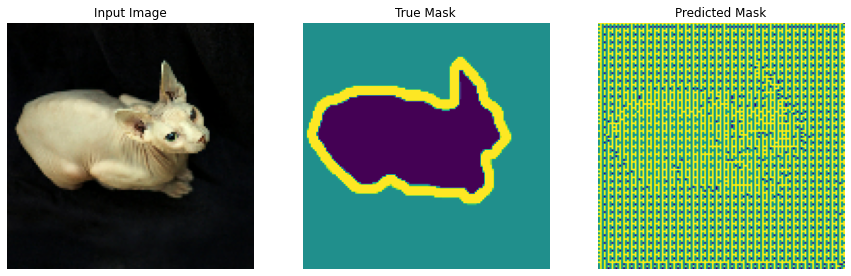

In [ ]:
mobile_net = mm.MobileNet(1, -1, 1001)
mobile_net.loading('./models/v3_small_float/model-388500')
the_input = tf.keras.Input(shape=(128, 128, 3))
the_output = mobile_net.propagating(the_input)
the_base = tf.keras.Model(inputs=the_input, outputs=the_output)

layer_names = [
  'MobilenetV3/expanded_conv/depthwise/',
  'MobilenetV3/expanded_conv_1/depthwise/',
  'MobilenetV3/expanded_conv_3/depthwise/',
  'MobilenetV3/expanded_conv_8/depthwise/',
  'MobilenetV3/Conv_1/']

output_layers = [the_base.get_layer(name).input for name in layer_names]
unet_encoder = tf.keras.Model(inputs=the_base.input, outputs=output_layers)
unet_encoder.trainable = False

unet_decoder = [
  image_upsampling(288*2, 3),
  image_upsampling(96*2, 3),
  image_upsampling(72*2, 3),
  image_upsampling(16*2, 3)]

unet_model = unet_modeling(unet_encoder, unet_decoder, 3)
unet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
image_displaying([
  sample_image,
  sample_mask,
  mask_creating(unet_model.predict(sample_image[tf.newaxis, ...]))])

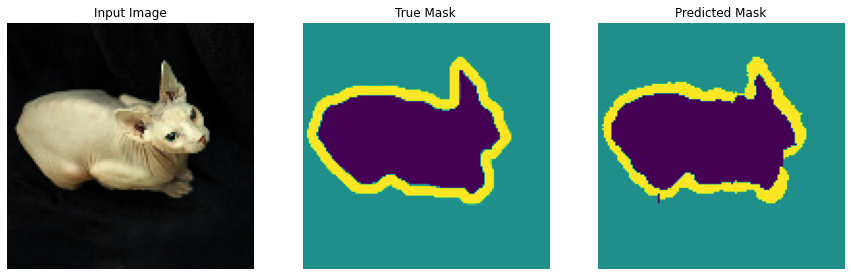


Sample prediction after epoch 20.

57/57 [==============================] - 11s 189ms/step - loss: 0.1260 - accuracy: 0.9424 - val_loss: 0.4520 - val_accuracy: 0.8641


In [ ]:
class DisplayCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    img, img_mask = sample_image, sample_mask
    image_displaying([img, img_mask, mask_creating(unet_model.predict(img[tf.newaxis, ...]))])
    print ('\nSample prediction after epoch {}.\n'.format(epoch+1))


model_history = unet_model.fit(
  training_dataset,
  epochs=EPOCH,
  steps_per_epoch=info.splits['train'].num_examples//BATCH,
  validation_steps=info.splits['test'].num_examples//BATCH//VAL,
  validation_data=test_dataset,
  callbacks=[DisplayCallback()])

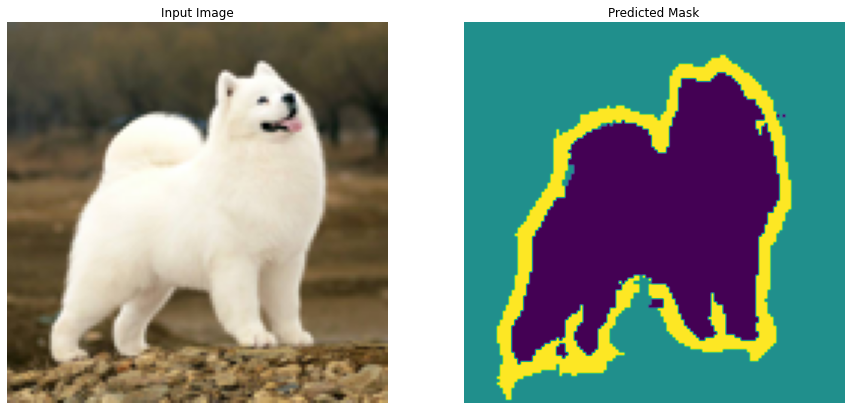

In [ ]:
img = np.array(PIL.Image.open('./models/samoyed.jpg').resize((128, 128)))
img = tf.cast(img, tf.float32)/255.0
image_displaying([img, mask_creating(unet_model.predict(img[tf.newaxis, ...]))], False)